## Trained the notebook on kaggle so change the paths and install librosa before running on local machine

In [1]:
#Audio Processing Libraries
import librosa
import librosa.display
from scipy import signal

#For Playing Audios
import IPython.display as ipd

#Array Processing
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Display the confusion matrix
from sklearn.metrics import confusion_matrix

#Deal with .pkl files
import pickle

#Create a dataframe
import pandas as pd

#Transform and encode the categorical targets
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Split dataset
from sklearn.model_selection import train_test_split

import os

# Exploring Dataset

##  Ambulance

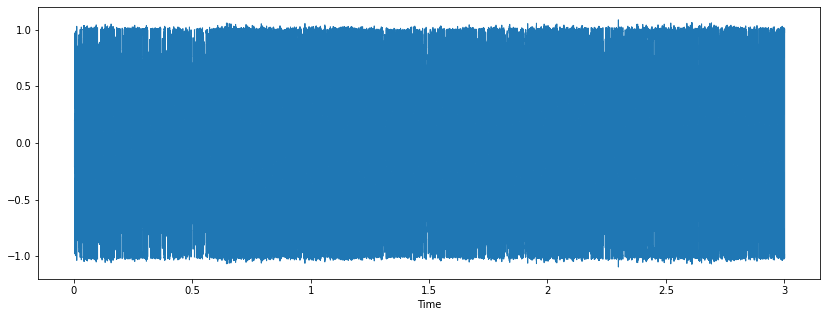

In [2]:
filename = "/kaggle/input/emergency-vehicle-sirens-with-traffic-noise/Dataset/Dataset/ambulance/mixed_sound_1.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

##  Firetruck

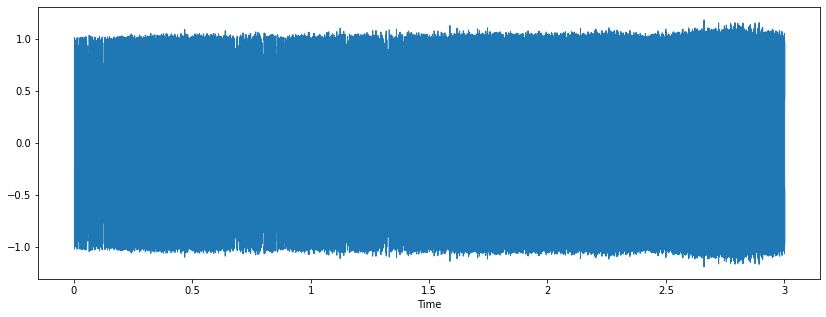

In [4]:
filename = "/kaggle/input/emergency-vehicle-sirens-with-traffic-noise/Dataset/Dataset/firetruck/mixed_sound_203.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

## Police Vehicle

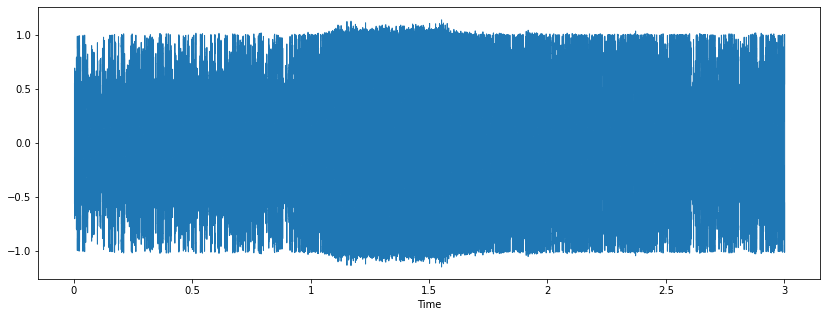

In [5]:
filename = "/kaggle/input/emergency-vehicle-sirens-with-traffic-noise/Dataset/Dataset/police/mixed_sound_602.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

## Traffic

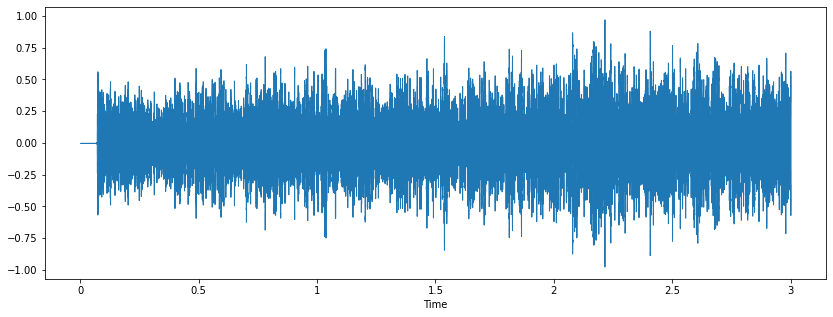

In [6]:
filename = "/kaggle/input/emergency-vehicle-sirens-with-traffic-noise/traffic/traffic/sound_401.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

## Using the function features_extractor to get a 80 MFCCs from each audio

In [7]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

## Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients

In [9]:
audio_dataset_path = '/kaggle/input/emergency-vehicle-sirens-with-traffic-noise/Dataset/Dataset/'

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+path+"/"+file
            data = features_extractor(file_name)  
            extracted_features.append([data, path])

In [11]:
traffic_dataset_path = "/kaggle/input/emergency-vehicle-sirens-with-traffic-noise/traffic/"
for path in os.listdir(traffic_dataset_path):
    for file in os.listdir(traffic_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = traffic_dataset_path+path+"/"+file
            data = features_extractor(file_name)  
            extracted_features.append([data, path])

In [12]:
#Saving data into a pkl file
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

In [13]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [14]:
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

,feature,class
0,"[46.926056, 169.24788, -29.12503, 22.353899, -...",ambulance
1,"[97.810844, 75.95197, -37.621925, 40.22298, -1...",ambulance
2,"[91.067986, 103.504616, -27.50882, 30.575985, ...",ambulance
3,"[50.446636, 153.8408, -34.12572, 20.474588, -5...",ambulance
4,"[105.97723, 107.950066, -34.177277, 30.894245,...",ambulance


In [15]:
df['class'].value_counts()

police       454
traffic      421
ambulance    400
firetruck    400
Name: class, dtype: int64

# Splitting the data into train and test sets

In [16]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [17]:
X.shape

(1675, 80)

In [18]:
Y.shape

(1675,)

#  Label Encoding

In [19]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [20]:
Y[0]

'ambulance'

In [21]:
y[0]

array([1., 0., 0., 0.], dtype=float32)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [23]:
y_train.shape

(1340, 4)

In [24]:
X_train.shape

(1340, 80)

In [25]:
X_test.shape

(335, 80)

In [26]:
y_test.shape

(335, 4)

In [27]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

#  CNN

In [36]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)

Reshaped Array Size (1340, 80, 1)


In [37]:
X_train.shape

(1340, 80)

In [38]:
def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))
    
    #First Conv1D layer
    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)
    
    #MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)
    
    #Dense Layer 
    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)
    
    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [39]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 3)             42        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 16)            544       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 16)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272   

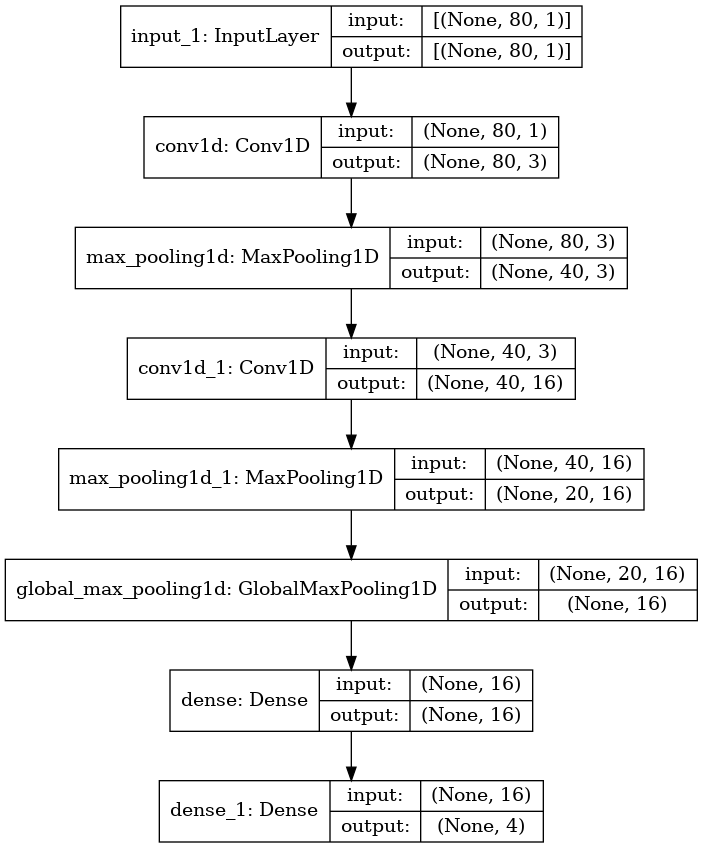

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [42]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200, 
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

Epoch 1/200
21/21 [==============================] - 1s 20ms/step - loss: 0.9601 - acc: 0.3067 - val_loss: 0.5940 - val_acc: 0.3522
Epoch 2/200
21/21 [==============================] - 0s 7ms/step - loss: 0.5347 - acc: 0.4716 - val_loss: 0.4915 - val_acc: 0.4597
Epoch 3/200
21/21 [==============================] - 0s 7ms/step - loss: 0.4434 - acc: 0.5590 - val_loss: 0.4278 - val_acc: 0.5731
Epoch 4/200
21/21 [==============================] - 0s 8ms/step - loss: 0.3906 - acc: 0.6269 - val_loss: 0.4026 - val_acc: 0.5791
Epoch 5/200
21/21 [==============================] - 0s 8ms/step - loss: 0.3642 - acc: 0.6373 - val_loss: 0.3632 - val_acc: 0.6299
Epoch 6/200
21/21 [==============================] - 0s 7ms/step - loss: 0.3368 - acc: 0.6933 - val_loss: 0.3447 - val_acc: 0.6567
Epoch 7/200
21/21 [==============================] - 0s 7ms/step - loss: 0.3235 - acc: 0.6993 - val_loss: 0.3333 - val_acc: 0.6657
Epoch 8/200
21/21 [==============================] - 0s 7ms/step - loss: 0.3138 - 

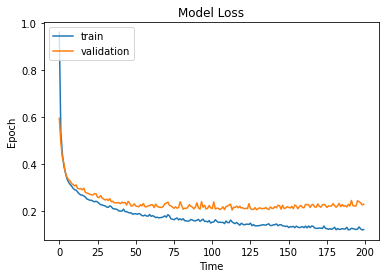

In [43]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [44]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

11/11 [==============================] - 0s 2ms/step - loss: 0.2291 - acc: 0.8209
Test Accuracy :  0.8208954930305481


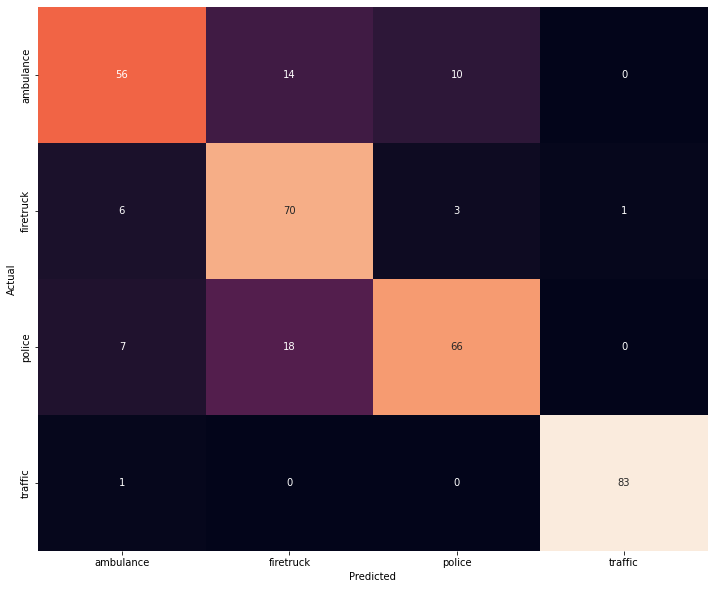

In [45]:
y_pred = model_cnn.predict(X_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [46]:
model_cnn.save('./CNN_Model')

#  LSTM

In [47]:
x_train_features  = X_train.reshape(len(X_train),-1, 80)
x_test_features = X_test.reshape(len(X_test), -1, 80)
print("Reshaped Array Size", x_train_features.shape)

Reshaped Array Size (1340, 1, 80)


In [48]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.5)(x)
    #dense
    x = Dense(64, activation='relu')(x)
    x = Dense(y_test.shape[1], activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [49]:
model_lstm = lstm(x_train_features)
model_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 80)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               107008    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 115,524
Trainable params: 115,524
Non-trainable params: 0
_________________________________________________________________


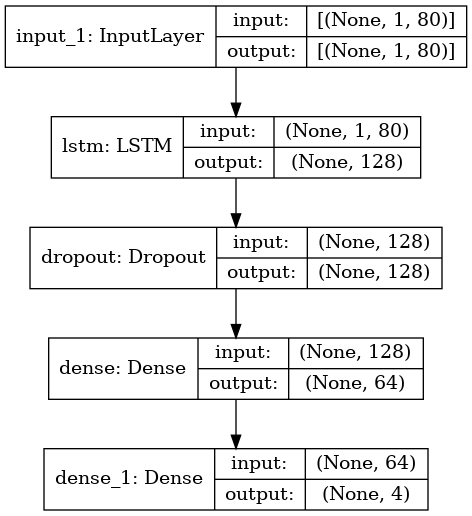

In [50]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [51]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [52]:
history = model_lstm.fit(x_train_features, y_train, epochs = 1000,
                        callbacks = [mc],
                        batch_size = 64, validation_data = (x_test_features, y_test))

Epoch 1/1000
21/21 [==============================] - 3s 35ms/step - loss: 0.5476 - acc: 0.3933 - val_loss: 0.4616 - val_acc: 0.5642

Epoch 00001: val_acc improved from -inf to 0.56418, saving model to best_model.hdf5
Epoch 2/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.4282 - acc: 0.5522 - val_loss: 0.3608 - val_acc: 0.6090

Epoch 00002: val_acc improved from 0.56418 to 0.60896, saving model to best_model.hdf5
Epoch 3/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.3609 - acc: 0.6127 - val_loss: 0.3285 - val_acc: 0.6687

Epoch 00003: val_acc improved from 0.60896 to 0.66866, saving model to best_model.hdf5
Epoch 4/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.3304 - acc: 0.6694 - val_loss: 0.3078 - val_acc: 0.6925

Epoch 00004: val_acc improved from 0.66866 to 0.69254, saving model to best_model.hdf5
Epoch 5/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.3040 - acc: 0.7149 - val_loss: 0.2843 - val_ac

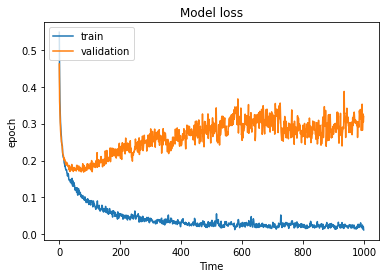

In [53]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [54]:
_,acc = model_lstm.evaluate(x_test_features, y_test)
print("Accuracy:", acc)

11/11 [==============================] - 0s 2ms/step - loss: 0.3194 - acc: 0.8716
Accuracy: 0.8716418147087097


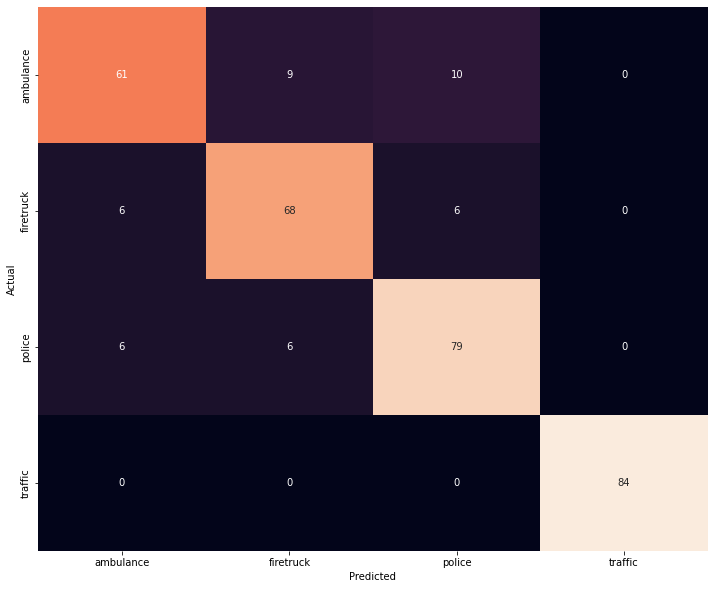

In [55]:
y_pred = model_lstm.predict(x_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [56]:
model_lstm.save('./LSTM')